# RAG 기반 영양 관리 시스템 튜토리얼

이 튜토리얼에서는 LangChain과 LangGraph를 사용하여 다음 기능을 구현합니다:

1. **추천 체인**: 요리명 입력 → 재료 분석 → 저칼륨/인 대체재 추천
2. **요약 체인**: 식약처 PDF 학습자료에서 조리법 추천 및 주의사항 요약, Q&A 생성
3. **문제 생성 체인**: 식약처 PDF 학습자료에서 주관식/객관식 문제 생성
4. **LangGraph 워크플로우**: 자동 라우팅으로 적절한 체인 선택

## 1. 환경 설정

In [36]:
# 필요한 패키지 설치 (처음 실행시)
# !pip install -r requirements.txt

In [37]:
import os
from dotenv import load_dotenv

# 환경변수 로드
load_dotenv()

# OpenAI API Key 확인
if not os.getenv("OPENAI_API_KEY"):

    raise ValueError("OPENAI_API_KEY not found. Please set it in .env file")
print("✅ 환경 설정 완료")


✅ 환경 설정 완료


## 2. RAG 시스템 초기화

PDF 파일을 로드하고 벡터스토어를 생성합니다.

In [38]:
from src.rag.rag_setup import RAGSetup

# RAG 설정 초기화
rag_setup = RAGSetup(
    pdf_directory="./data/pdf",
    vectorstore_path="./data/vectorstore",
    chunk_size=300,
    chunk_overlap=30
)

# 벡터스토어 생성 또는 로드
# force_rebuild=True로 설정하면 기존 벡터스토어를 무시하고 새로 생성합니다
vectorstore = rag_setup.setup_rag(force_rebuild=False)

print("\n✅ RAG 시스템 초기화 완료")

Loading existing vector store...
Vector store loaded from data/vectorstore/faiss_index

✅ RAG 시스템 초기화 완료


## 3. 개별 체인 구현

### 3.1 추천 체인 (Recommendation Chain)

요리명을 입력받아 재료를 분석하고 저칼륨/인 대체재를 추천합니다.

In [39]:

from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from src.rag.retriever import create_retriever
from src.utils.web_search import search_for_nutrition_info

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

# Retriever 생성
retriever = create_retriever(vectorstore, retriever_type="basic", k=4)

# 1단계: 요리 재료 추출용 프롬프트
ingredient_extraction_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 요리 전문가입니다. 주어진 요리명에 대해 일반적으로 사용되는 재료들을 나열해주세요.

참고 자료:
{context}

재료명, 단백질, 나트륨, 칼륨, 인과 칼로리들을 나열하되, 각 재료는 줄바꿈으로 구분해주세요. 이때 용량은 mg으로 통일햐되 고지하세요.

만성신부전 환자의 영양 관리는 질환 단계(투석 전·중·이식 후)에 따라 달라지며, 다음의 6가지 조건을 중심으로 조정해야 합니다.
1. 조건 1은 **단백질 섭취**로, 투석 전에는 체중 1kg당 0.6~0.8g 수준의 저단백 식이를 유지해야 합니다. 투석 중에는 단백질 손실이 많아 체중 1kg당 1.2~1.3g의 고단백 식이가 필요하며, 이식 후에는 0.8~1.0g 정도로 조절해 과잉 섭취를 방지합니다.
2. 조건 2는 **나트륨(소금)** 섭취 제한이다. 투석 전에는 하루 5g 미만, 투석 중과 이식 후에는 하루 6g 미만으로 유지하며, 이는 고혈압과 부종을 예방하기 위한 조치입니다.
3. 조건 3은 **칼륨 섭취** 관리이다. 투석 전에는 하루 2000mg 미만을 권장하며, 투석 중에도 동일하게 유지하되 혈중 칼륨 농도에 따라 조정합니다. 이식 후에는 신기능이 회복되면 다소 완화할 수 있으나, 고칼륨혈증 위험이 있는 경우 주의가 필요합니다.
4. 조건 4는 **인(Phosphorus)** 섭취 조절이다. 투석 전에는 하루 800mg 미만, 투석 중에는 1000mg 미만, 이식 후에는 1200mg 미만으로 제한하며, 이는 뼈와 혈관의 석회화를 방지하기 위합입니다.
5. 조건 5은 **에너지 섭취량**이다. 투석 전과 투석 중에는 체중 1kg당 30~35kcal, 이식 후에는 30kcal 정도를 유지하며, 이는 체중을 안정적으로 유지하기 위한 목접입니다.
6. 조건 6는 각 영양소 섭취량을 기준으로 권장량의 0~80%는 안전 구간(녹색), 80~100%는 주의 구간(노란색), 100% 초과는 위험 구간(빨간색)으로 구분하여 식단의 안전성과 과잉 섭취를 판단하는 기준이다. 각 영양소에 대해서 녹색, 노란색, 빨간색으로 표시하세요.
"""),
    ("user", "요리명: {dish_name}")
])

# 2단계: 컨텍스트 검색 함수 (RAG + 웹 검색)
def get_context_for_ingredients(dish_name_input: dict):
    """재료 추출을 위한 컨텍스트 검색 (RAG + 웹 검색 Fallback)"""
    dish_name = dish_name_input["dish_name"]
    query = f"{dish_name} 재료 레시피"

    # 1. RAG 검색 시도
    docs = retriever.retrieve(query)
    total_length = sum(len(doc.page_content) for doc in docs)
    min_required_length = 300

    if total_length >= min_required_length:
        # RAG 검색 결과 충분
        context = "\n\n".join([doc.page_content for doc in docs])
        print(f"✅ '{dish_name}' RAG 검색 결과 사용")
    else:
        # Fallback: 웹 검색
        print(f"⚠️ '{dish_name}' RAG 검색 결과 부족 → 웹 검색 실행 중...")
        rag_context = "\n\n".join([doc.page_content for doc in docs]) if docs else "검색 결과 없음"
        web_results = search_for_nutrition_info(f"{dish_name} 레시피 재료", max_results=2)
        context = f"[RAG 검색 결과]\n{rag_context}\n\n[웹 검색 결과]\n{web_results}"
        print("✅ RAG + 웹 검색 결과 결합 완료")

    return {"dish_name": dish_name, "context": context}

# 3단계: Runnable 체인 정의
ingredient_chain = (
    RunnablePassthrough.assign(context=get_context_for_ingredients)
    | ingredient_extraction_prompt
    | llm
    | StrOutputParser()
)

# 4단계: 테스트 실행
dish_name = "김치찌개"
result = ingredient_chain.invoke({"dish_name": dish_name})

print("🔹 [추출된 재료 목록]")
print(result)

✅ '김치찌개' RAG 검색 결과 사용
🔹 [추출된 재료 목록]
김치찌개에 일반적으로 사용되는 재료는 다음과 같습니다:

- 김치
- 두부
- 돼지고기 (또는 소고기, 해산물)
- 대파
- 마늘
- 생강
- 고춧가루
- 국간장 (또는 소금)
- 물 (육수)
- 버섯 (optional)
- 애호박 (optional)

각 재료에 포함된 영양소 수치에 대한 정보는 다음과 같습니다:

**김치**
- 단백질: 약 1g
- 나트륨: 약 500mg
- 칼륨: 약 300mg
- 인: 약 20mg
- 칼로리: 약 30kcal

**두부**
- 단백질: 약 8g
- 나트륨: 약 5mg
- 칼륨: 약 200mg
- 인: 약 100mg
- 칼로리: 약 70kcal

**돼지고기 (100g 기준)**
- 단백질: 약 20g
- 나트륨: 약 60mg
- 칼륨: 약 300mg
- 인: 약 200mg
- 칼로리: 약 250kcal

**대파**
- 단백질: 약 1g
- 나트륨: 약 10mg
- 칼륨: 약 200mg
- 인: 약 10mg
- 칼로리: 약 30kcal

**마늘**
- 단백질: 약 1g
- 나트륨: 약 1mg
- 칼륨: 약 150mg
- 인: 약 10mg
- 칼로리: 약 4kcal

**생강**
- 단백질: 약 1g
- 나트륨: 약 1mg
- 칼륨: 약 50mg
- 인: 약 5mg
- 칼로리: 약 5kcal

**고춧가루**
- 단백질: 약 1g
- 나트륨: 약 2mg
- 칼륨: 약 120mg
- 인: 약 10mg
- 칼로리: 약 20kcal

**국간장**
- 단백질: 약 1g
- 나트륨: 약 800mg
- 칼륨: 약 10mg
- 인: 약 0mg
- 칼로리: 약 10kcal

**물 (육수)**
- 단백질: 0g
- 나트륨: 0mg
- 칼륨: 0mg
- 인: 0mg
- 칼로리: 0kcal

**버섯 (optional)**
- 단백질: 약 3g
- 나트륨: 약 5mg
- 칼륨: 약 300mg
- 인: 약 20mg
- 칼로리: 약 15kcal

**애호박 (optional)

In [40]:
# 2단계: RAG 기반 대체재 추천 체인 + 웹 검색 Fallback

# 대체재 추천 프롬프트
recommendation_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 신장 질환 환자를 위한 영양 전문가입니다.
주어진 요리 재료들을 분석하고, 식약처 자료를 참고하여 저칼륨/저인 대체재를 추천해주세요.

참고 자료:
{context}

다음 형식으로 답변해주세요:
1. 고칼륨/고인 재료 분석
2. 추천 대체재
3. 조리 팁"""),
    ("user", """요리: {dish_name}
재료:
{ingredients}

위 재료들 중 신장 질환 환자에게 부담이 될 수 있는 재료와 대체재를 가장 부담이 되는 원본 재료 순으로 나열해서 추천해주세요.
재료명, 단백질, 나트륨, 칼륨, 인과 칼로리들을 나열하되, 각 재료는 줄바꿈으로 구분해주세요. 이때 용량은 mg으로 통일햐되 고지하세요.
추천하는 대체제의 재료명, 단백질, 나트륨, 칼륨, 인과 칼로리들을 나열하되, 화살표로 대체된 항목을 표시합니다.


만성신부전 환자의 영양 관리는 질환 단계(투석 전·중·이식 후)에 따라 달라지며, 다음의 6가지 조건을 중심으로 조정해야 합니다.
1. 조건 1은 **단백질 섭취**로, 투석 전에는 체중 1kg당 0.6~0.8g 수준의 저단백 식이를 유지해야 합니다. 투석 중에는 단백질 손실이 많아 체중 1kg당 1.2~1.3g의 고단백 식이가 필요하며, 이식 후에는 0.8~1.0g 정도로 조절해 과잉 섭취를 방지합니다.
2. 조건 2는 **나트륨(소금)** 섭취 제한이다. 투석 전에는 하루 5g 미만, 투석 중과 이식 후에는 하루 6g 미만으로 유지하며, 이는 고혈압과 부종을 예방하기 위한 조치입니다.
3. 조건 3은 **칼륨 섭취** 관리이다. 투석 전에는 하루 2000mg 미만을 권장하며, 투석 중에도 동일하게 유지하되 혈중 칼륨 농도에 따라 조정합니다. 이식 후에는 신기능이 회복되면 다소 완화할 수 있으나, 고칼륨혈증 위험이 있는 경우 주의가 필요합니다.
4. 조건 4는 **인(Phosphorus)** 섭취 조절이다. 투석 전에는 하루 800mg 미만, 투석 중에는 1000mg 미만, 이식 후에는 1200mg 미만으로 제한하며, 이는 뼈와 혈관의 석회화를 방지하기 위합입니다.
5. 조건 5은 **에너지 섭취량**이다. 투석 전과 투석 중에는 체중 1kg당 30~35kcal, 이식 후에는 30kcal 정도를 유지하며, 이는 체중을 안정적으로 유지하기 위한 목접입니다.
6. 조건 6는 각 영양소 섭취량을 기준으로 권장량의 0~80%는 안전 구간(녹색), 80~100%는 주의 구간(노란색), 100% 초과는 위험 구간(빨간색)으로 구분하여 식단의 안전성과 과잉 섭취를 판단하는 기준이다. 각 영양소에 대해서 녹색, 노란색, 빨간색으로 표시하세요.
     """)
])

def get_context_for_recommendation(inputs):
    """추천을 위한 컨텍스트 검색 (RAG + 웹 검색 Fallback)"""
    dish_name = inputs['dish_name']
    
    # 1. RAG 검색 시도
    query = f"저칼륨 저인 식품 대체재 {dish_name}"
    docs = retriever.retrieve(query)
    
    # 문서의 품질 확인 (최소 길이 체크)
    total_length = sum(len(doc.page_content) for doc in docs)
    min_required_length = 500  # 최소 500자
    
    if total_length >= min_required_length:
        # RAG 검색 결과가 충분함
        context = "\n\n".join([doc.page_content for doc in docs])
        print("✅ 대체재 추천: RAG 검색 결과 사용")
    else:
        # RAG 검색 결과가 부족 -> 웹 검색 Fallback
        print("⚠️ 대체재 추천: RAG 검색 결과 부족 -> 웹 검색 실행 중...")
        
        # RAG 결과
        rag_context = "\n\n".join([doc.page_content for doc in docs])
        
        # 웹 검색 추가
        web_results = search_for_nutrition_info(query, max_results=3)
        
        # RAG + 웹 검색 결과 결합
        context = f"[RAG 검색 결과]\n{rag_context}\n\n[웹 검색 결과]\n{web_results}"
        print("✅ RAG + 웹 검색 결과 결합 완료")
    
    return {**inputs, "context": context}


# 테스트
dish_name = "김치찌개"
print(f"\n{'='*50}")
print(f"🔍 추천 체인 실행: {dish_name}")
print(f"{'='*50}\n")

# 1단계: 재료 추출
print("📝 1단계: 재료 추출 중...")
ingredients = ingredient_chain.invoke({"dish_name": dish_name})

# 2단계: 컨텍스트 검색 및 추천
print("\n🔍 2단계: 대체재 추천 중...")

inputs_with_context = get_context_for_recommendation({
    "dish_name": dish_name,
    "ingredients": ingredients
})

# 3단계: LLM으로 최종 추천 생성
print("\n💡 3단계: 최종 추천 생성 중...\n")
recommendation_chain = recommendation_prompt | llm | StrOutputParser()
result = recommendation_chain.invoke(inputs_with_context)
print(f"\n{'='*50}")
print("최종 결과:")
print(f"{'='*50}\n")

print(result)


🔍 추천 체인 실행: 김치찌개

📝 1단계: 재료 추출 중...
✅ '김치찌개' RAG 검색 결과 사용

🔍 2단계: 대체재 추천 중...
✅ 대체재 추천: RAG 검색 결과 사용

💡 3단계: 최종 추천 생성 중...


최종 결과:

### 1. 고칼륨/고인 재료 분석

**김치**
- 단백질: 10mg
- 나트륨: 800mg (위험 구간)
- 칼륨: 300mg (노란색)
- 인: 50mg (녹색)
- 칼로리: 40kcal (녹색)

**돼지고기 (100g 기준)**
- 단백질: 25g
- 나트륨: 60mg (녹색)
- 칼륨: 350mg (노란색)
- 인: 180mg (노란색)
- 칼로리: 300kcal (녹색)

**두부 (100g 기준)**
- 단백질: 8g
- 나트륨: 15mg (녹색)
- 칼륨: 150mg (녹색)
- 인: 100mg (노란색)
- 칼로리: 70kcal (녹색)

**대파 (100g 기준)**
- 단백질: 2g
- 나트륨: 10mg (녹색)
- 칼륨: 200mg (녹색)
- 인: 30mg (녹색)
- 칼로리: 32kcal (녹색)

**마늘 (10g 기준)**
- 단백질: 0.5g
- 나트륨: 3mg (녹색)
- 칼륨: 20mg (녹색)
- 인: 10mg (녹색)
- 칼로리: 15kcal (녹색)

**고춧가루 (10g 기준)**
- 단백질: 2g
- 나트륨: 0mg (녹색)
- 칼륨: 50mg (녹색)
- 인: 5mg (녹색)
- 칼로리: 30kcal (녹색)

**국간장 (10g 기준)**
- 단백질: 1g
- 나트륨: 900mg (위험 구간)
- 칼륨: 20mg (녹색)
- 인: 0mg (녹색)
- 칼로리: 10kcal (녹색)

**물 (0g 기준)**
- 단백질: 0g
- 나트륨: 0mg (녹색)
- 칼륨: 0mg (녹색)
- 인: 0mg (녹색)
- 칼로리: 0kcal (녹색)

**생강 (10g 기준)**
- 단백질: 0.2g
- 나트륨: 2mg (녹색)
- 칼륨: 10mg (녹색)
- 인: 3mg (녹색)
- 칼로리:

### 3.2 요약 체인 (Summary Chain)

식약처 PDF에서 조리법과 주의사항을 검색하고 요약하며, Q&A를 생성합니다.

In [41]:
summary_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 신장 질환 환자를 위한 영양 교육 전문가입니다.
식약처 자료를 바탕으로 조리법과 주의사항을 요약하고, 이해를 돕는 Q&A를 생성해주세요.

참고 자료:
{context}

다음 형식으로 답변해주세요:
## 조리법 요약
(핵심 조리법 2-3가지)

## 주의사항
(반드시 지켜야 할 주의사항 2-3가지)

## Q&A
(자주 묻는 질문과 답변 2-3개)
     
     
만성신부전 환자의 영양 관리는 질환 단계(투석 전·중·이식 후)에 따라 달라지며, 다음의 6가지 조건을 중심으로 조정해야 합니다.
1. 조건 1은 **단백질 섭취**로, 투석 전에는 체중 1kg당 0.6~0.8g 수준의 저단백 식이를 유지해야 합니다. 투석 중에는 단백질 손실이 많아 체중 1kg당 1.2~1.3g의 고단백 식이가 필요하며, 이식 후에는 0.8~1.0g 정도로 조절해 과잉 섭취를 방지합니다.
2. 조건 2는 **나트륨(소금)** 섭취 제한이다. 투석 전에는 하루 5g 미만, 투석 중과 이식 후에는 하루 6g 미만으로 유지하며, 이는 고혈압과 부종을 예방하기 위한 조치입니다.
3. 조건 3은 **칼륨 섭취** 관리이다. 투석 전에는 하루 2000mg 미만을 권장하며, 투석 중에도 동일하게 유지하되 혈중 칼륨 농도에 따라 조정합니다. 이식 후에는 신기능이 회복되면 다소 완화할 수 있으나, 고칼륨혈증 위험이 있는 경우 주의가 필요합니다.
4. 조건 4는 **인(Phosphorus)** 섭취 조절이다. 투석 전에는 하루 800mg 미만, 투석 중에는 1000mg 미만, 이식 후에는 1200mg 미만으로 제한하며, 이는 뼈와 혈관의 석회화를 방지하기 위합입니다.
5. 조건 5은 **에너지 섭취량**이다. 투석 전과 투석 중에는 체중 1kg당 30~35kcal, 이식 후에는 30kcal 정도를 유지하며, 이는 체중을 안정적으로 유지하기 위한 목접입니다.
6. 조건 6는 각 영양소 섭취량을 기준으로 권장량의 0~80%는 안전 구간(녹색), 80~100%는 주의 구간(노란색), 100% 초과는 위험 구간(빨간색)으로 구분하여 식단의 안전성과 과잉 섭취를 판단하는 기준이다.

     """),
    ("user", "주제: {topic}\n\n위 주제에 대해 조리법, 주의사항, Q&A를 생성해주세요.")
])

def get_context_for_summary(inputs):
    """요약을 위한 컨텍스트 검색 (RAG + 웹 검색 Fallback)"""
    topic = inputs["topic"]
    
    # 1. RAG 검색 시도
    docs = retriever.retrieve(topic)
    
    # 문서의 품질 확인
    total_length = sum(len(doc.page_content) for doc in docs)
    min_required_length = 500
    
    if total_length >= min_required_length:
        context = "\n\n".join([doc.page_content for doc in docs])
        print("✅ RAG 검색 결과 사용")
    else:
        # RAG 검색 결과가 부족 -> 웹 검색 Fallback
        print("⚠️ RAG 검색 결과 부족 -> 웹 검색 실행 중...")
        
        rag_context = "\n\n".join([doc.page_content for doc in docs])
        web_results = search_for_nutrition_info(topic, max_results=3)
        
        context = f"[RAG 검색 결과]\n{rag_context}\n\n[웹 검색 결과]\n{web_results}"
        print("✅ RAG + 웹 검색 결과 결합 완료")
    
    return {**inputs, "context": context}

# 요약 체인 구성
summary_chain = (
    get_context_for_summary
    | summary_prompt
    | llm
    | StrOutputParser()
)

# 테스트
print("\n" + "="*50)
print("📝 요약 체인 실행")
print("="*50 + "\n")

topic = "저염식 조리법"
result = summary_chain.invoke({"topic": topic})
print(result)


📝 요약 체인 실행

✅ RAG 검색 결과 사용
## 조리법 요약
1. **재료 손질**: 각종 채소(배추, 무, 쪽파 등)는 깨끗이 씻고, 필요에 따라 적당한 크기로 자른다. 배추는 세로로 칼집을 내어 소금을 치고 절이기 전에 시간을 최소화하여 나트륨을 줄인다.
2. **양념 만들기**: 고춧가루, 설탕, 다진 마늘, 생강, 그리고 젓갈 등으로 양념을 만들어 손질한 재료와 함께 버무린다. 이때, 소금 대신 젓갈을 사용하는 방법으로 나트륨 섭취를 줄인다.
3. **조리 방법**: 두부를 굽고, 느타리버섯과 같은 재료를 올리브유에 볶아 준비한다. 볶은 재료에 발사믹크림이나 올리고당을 추가하여 소스를 만들고, 두부 위에 소스를 올려 완성한다.

## 주의사항
1. **나트륨 섭취 제한**: 저염식 식단을 유지하기 위해 나트륨 함량이 높은 재료(소금, 간장, 젓갈 등)의 사용을 최소화하고, 대체 재료를 활용한다.
2. **재료 선택**: 신선한 채소와 저염 식재료를 우선적으로 선택하여 조리한다. 가공식품은 가능한 한 피하고, 자연 재료를 사용한다.
3. **조리 시 맛 조절**: 싱거운 맛을 보완하기 위해 식초, 레몬즙 등을 사용하여 신맛을 더하고, 견과류나 두부를 추가해 고소한 맛을 내도록 한다.

## Q&A
**Q1: 저염식 식단을 위해 어떤 재료를 선택해야 하나요?**  
A1: 가능한 한 신선한 채소와 저염 재료를 선택하세요. 예를 들어, 두부, 느타리버섯, 다양한 생채소(상추, 시금치 등)를 활용할 수 있습니다. 가공식품보다는 자연 재료를 사용하는 것이 좋습니다.

**Q2: 저염식을 하면서 맛을 어떻게 유지할 수 있나요?**  
A2: 맛을 유지하기 위해 발사믹크림, 올리고당, 식초, 레몬즙 등을 활용하여 요리에 신맛과 단맛을 추가하세요. 또한, 견과류나 두부를 넣어 고소한 맛을 보완할 수 있습니다.

**Q3: 저염식 요리를 위해 절임 음식은 어떻게 조리해야 하나요?**  
A3: 절임 음식은 소금 대신 젓갈을 사용하거나, 절이는 시간을 최소화하여 

### 3.3 문제 생성 체인 (Quiz Generation Chain)

식약처 PDF에서 주관식/객관식 문제 3개를 생성합니다.

In [42]:
# 문제 생성 프롬프트
quiz_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 영양학 교육 문제 출제 전문가입니다.
식약처 자료를 바탕으로 학습 효과를 높이는 문제를 출제해주세요.

참고 자료:
{context}

다음 형식으로 정확히 3개의 문제를 출제해주세요:

**문제 1 (객관식)**
[문제 내용]
1) 선택지 1
2) 선택지 2
3) 선택지 3
4) 선택지 4

정답: [번호]
해설: [간단한 해설]

**문제 2 (객관식)**
[문제 내용]
1) 선택지 1
2) 선택지 2
3) 선택지 3
4) 선택지 4

정답: [번호]
해설: [간단한 해설]

**문제 3 (주관식)**
[문제 내용]

정답: [정답 내용]
해설: [간단한 해설]"""),
    ("user", "주제: {topic}\n\n위 주제에 대해 객관식 2문제, 주관식 1문제를 출제해주세요.")
])

def get_context_for_quiz(inputs):
    """문제 생성을 위한 컨텍스트 검색"""
    topic = inputs["topic"]
    # 더 많은 문서를 가져와서 다양한 문제 생성
    docs = retriever.retriever.invoke(topic)  # k=4 사용
    context = "\n\n".join([doc.page_content for doc in docs])
    return {**inputs, "context": context}

# 문제 생성 체인 구성
quiz_chain = (
    get_context_for_quiz
    | quiz_prompt
    | llm
    | StrOutputParser()
)

# 테스트
print("\n" + "="*50)
print("❓ 문제 생성 체인 실행")
print("="*50 + "\n")

topic = "혈액투석 환자의 영양 관리"
result = quiz_chain.invoke({"topic": topic})
print(result)


❓ 문제 생성 체인 실행

**문제 1 (객관식)**  
혈액투석 환자에게 적절한 단백질 섭취량은 하루에 몇 그램으로 권장되는가?  
1) 0.6g/kg  
2) 0.8g/kg  
3) 1.0g/kg  
4) 1.2g/kg  

정답: 4  
해설: 혈액투석 환자는 단백질 손실이 많기 때문에 하루에 1.2g/kg의 단백질 섭취가 권장됩니다.

---

**문제 2 (객관식)**  
혈액투석 환자가 나트륨 섭취를 줄여야 하는 이유는 무엇인가?  
1) 고혈압 예방  
2) 체중 감소  
3) 피부 건강 증진  
4) 비타민 D 합성 증가  

정답: 1  
해설: 혈액투석 환자는 나트륨 섭취를 줄여야 고혈압을 예방하고 체액 저류를 방지할 수 있습니다.

---

**문제 3 (주관식)**  
혈액투석 환자가 식사 시 고려해야 할 주요 영양소 두 가지는 무엇인지 서술하시오.  

정답: 단백질, 칼륨  
해설: 혈액투석 환자는 단백질 섭취를 충분히 하면서도 칼륨과 인의 섭취를 조절해야 합니다. 이는 신장 기능이 저하된 환자에게 중요한 영양 관리 요소입니다.


# 노드 함수 정의

1. 사용자 의도 분류 노드

2, 추천 노드

3, 요약 노드

4, 문제 생성 노드


# 라우터 함수

def route_intent(state: WorkflowState) -> Literal["recommendation", "summary", "quiz"]:
    """의도에 따라 다음 노드를 결정합니다."""
    intent = state["intent"]
    
    if "recommendation" in intent:
        return "recommendation"
    elif "quiz" in intent:
        return "quiz"
    else:
        return "summary"

print("✅ 노드 함수 정의 완료")

In [43]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END

# 상태 정의
class WorkflowState(TypedDict):
    """워크플로우 상태"""
    query: str  # 사용자 입력
    intent: str  # 의도 분류 결과
    result: str  # 최종 결과

# 의도 분류 프롬프트
intent_classification_prompt = ChatPromptTemplate.from_messages([
    ("system", """당신은 사용자 의도를 분류하는 전문가입니다.
사용자의 질문을 분석하여 다음 중 하나로 분류해주세요:

1. recommendation - 요리 재료 대체재 추천 요청
   예: "김치찌개 만들 때 뭘 대체할 수 있을까?", "불고기에서 저칼륨 재료 추천해줘"

2. summary - 조리법, 주의사항 요약 또는 정보 제공 요청
   예: "저염식 조리법 알려줘", "신장 질환자 식사 주의사항은?"

3. quiz - 문제 출제 요청
   예: "영양 관리 퀴즈 만들어줘", "문제 출제해줘"

반드시 'recommendation', 'summary', 'quiz' 중 하나만 답변하세요."""),
    ("user", "{query}")
])

intent_classifier = intent_classification_prompt | llm | StrOutputParser()

print("✅ LangGraph 구성 요소 준비 완료")

✅ LangGraph 구성 요소 준비 완료


In [44]:
# 노드 함수 정의

def classify_intent(state: WorkflowState) -> WorkflowState:
    """사용자 의도를 분류합니다."""
    query = state["query"]
    intent = intent_classifier.invoke({"query": query}).strip().lower()
    
    print(f"\n🎯 의도 분류: {intent}")
    
    return {**state, "intent": intent}

def extract_dish_name(query: str) -> str:
    """사용자 질문에서 요리명을 추출합니다."""
    extract_dish_prompt = ChatPromptTemplate.from_messages([
        ("system", "사용자의 질문에서 요리명만 추출하세요. 한 단어 또는 짧은 구문만 반환하세요."),
        ("user", "{query}")
    ])
    dish_extractor = extract_dish_prompt | llm | StrOutputParser()
    dish_name = dish_extractor.invoke({"query": query})
    return dish_name.strip()

def run_recommendation(state: WorkflowState) -> WorkflowState:
    """추천 체인을 실행합니다."""
    print("\n🍳 추천 체인 실행 중...")

    # 요리명 추출
    dish_name = extract_dish_name(state["query"])
    print(f"추출된 요리명: {dish_name}")

    ingredients = ingredient_chain.invoke({'dish_name': dish_name})

    inputs_with_context = get_context_for_recommendation({
        "dish_name": dish_name,
        "ingredients": ingredients
    })

    result = recommendation_chain.invoke(inputs_with_context)

    return {**state, "result": result}

def run_summary(state: WorkflowState) -> WorkflowState:
    """요약 체인을 실행합니다."""
    print("\n📝 요약 체인 실행 중...")
    
    result = summary_chain.invoke({"topic": state["query"]})
    return {**state, "result": result}

def run_quiz(state: WorkflowState) -> WorkflowState:
    """문제 생성 체인을 실행합니다."""
    print("\n❓ 문제 생성 체인 실행 중...")
    
    result = quiz_chain.invoke({"topic": state["query"]})
    return {**state, "result": result}

# 라우터 함수
def route_intent(state: WorkflowState) -> Literal["recommendation", "summary", "quiz"]:
    """의도에 따라 다음 노드를 결정합니다."""
    intent = state["intent"]
    
    if "recommendation" in intent:
        return "recommendation"
    elif "quiz" in intent:
        return "quiz"
    else:
        return "summary"

print("✅ 노드 함수 정의 완료")

✅ 노드 함수 정의 완료


In [45]:
# LangGraph 구성
workflow = StateGraph(WorkflowState)

# 노드 추가
workflow.add_node("classifier", classify_intent)
workflow.add_node("recommendation", run_recommendation)
workflow.add_node("summary", run_summary)
workflow.add_node("quiz", run_quiz)

# 엣지 추가
workflow.set_entry_point("classifier")
workflow.add_conditional_edges(
    "classifier",
    route_intent,
    {
        "recommendation": "recommendation",
        "summary": "summary",
        "quiz": "quiz"
    }
)

# 각 체인 노드에서 종료로 연결
workflow.add_edge("recommendation", END)
workflow.add_edge("summary", END)
workflow.add_edge("quiz", END)

# 그래프 컴파일
app = workflow.compile()

print("✅ LangGraph 워크플로우 컴파일 완료")

✅ LangGraph 워크플로우 컴파일 완료


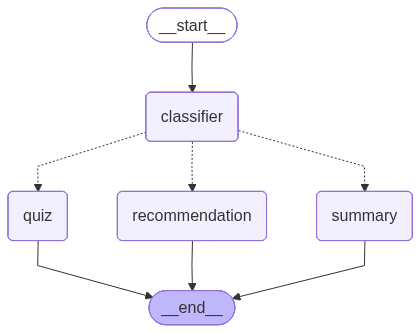

In [46]:
try:
    from IPython.display import Image, display
    
    # Mermaid 다이어그램으로 시각화
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"시각화 실패 (그래프는 정상 작동합니다): {e}")

## 5. 워크플로우 테스트

다양한 쿼리로 자동 라우팅을 테스트합니다.

In [47]:
# 테스트 쿼리들
test_queries = [
    "된장찌개 만들 때 저칼륨 재료로 대체할 수 있는 게 뭐야?",
    "혈액투석 환자의 식사 관리 주의사항 요약해줘",
    "저염식에 대한 퀴즈 3개 만들어줘"
]

for i, query in enumerate(test_queries, 1):
    print("\n" + "="*70)
    print(f"테스트 {i}: {query}")
    print("="*70)
    
    
    # 워크플로우 실행
    result = app.invoke({"query": query})
    
    print("\n" + "-"*70)
    print("결과:")
    print("-"*70)
    print(result["result"])
    print("\n")



테스트 1: 된장찌개 만들 때 저칼륨 재료로 대체할 수 있는 게 뭐야?

🎯 의도 분류: recommendation

🍳 추천 체인 실행 중...
추출된 요리명: 된장찌개
✅ '된장찌개' RAG 검색 결과 사용
✅ 대체재 추천: RAG 검색 결과 사용

----------------------------------------------------------------------
결과:
----------------------------------------------------------------------
### 1. 고칼륨/고인 재료 분석

#### 일반 재료
- **된장 (Fermented soybean paste)**
  - 단백질: 120g
  - 나트륨: 3,800mg
  - 칼륨: 500mg
  - 인: 700mg
  - 칼로리: 160kcal

- **두부 (Tofu)**
  - 단백질: 80g
  - 나트륨: 10mg
  - 칼륨: 200mg
  - 인: 200mg
  - 칼로리: 70kcal

- **호박 (Zucchini)**
  - 단백질: 1g
  - 나트륨: 2mg
  - 칼륨: 300mg
  - 인: 20mg
  - 칼로리: 20kcal

- **대파 (Green onion)**
  - 단백질: 1g
  - 나트륨: 5mg
  - 칼륨: 300mg
  - 인: 30mg
  - 칼로리: 30kcal

- **감자 (Potato)**
  - 단백질: 2g
  - 나트륨: 10mg
  - 칼륨: 500mg
  - 인: 30mg
  - 칼로리: 80kcal

- **버섯 (Mushrooms, e.g., shiitake or enoki)**
  - 단백질: 3g
  - 나트륨: 5mg
  - 칼륨: 400mg
  - 인: 25mg
  - 칼로리: 30kcal

- **마늘 (Garlic)**
  - 단백질: 6g
  - 나트륨: 2mg
  - 칼륨: 150mg
  - 인: 10mg
  - 칼로리: 150kcal

- **고춧가루 (Red 

## 정리

이 튜토리얼에서 구현한 내용:

1. **RAG 시스템**: 식약처 PDF 문서를 벡터스토어로 구축
2. **추천 체인**: 요리 재료 분석 및 저칼륨/인 대체재 추천
3. **요약 체인**: 조리법 및 주의사항 요약, Q&A 생성
4. **문제 생성 체인**: 주관식/객관식 문제 자동 생성
5. **LangGraph 워크플로우**: 자동 의도 분류 및 라우팅
